In [1]:
from pyts.decomposition import SingularSpectrumAnalysis
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

Погода в Южно-Сахалинске с 2019 года.

In [2]:
ts_path = r'E:\python_projects\notebooks\timeseries\Погода в Ю-Сахалинске.xlsx'
data = pd.read_excel(ts_path, index_col='Дата')
data

,Максимальная температура,Минимальная температура,Средняя температура,Скорость ветра,Осадки,Эффективная температура
Дата,,,,,,
2019-01-01,-5.3,-20.0,-11.4,4,0.0,-16.8
2019-01-02,-6.0,-22.0,-13.2,2,0.0,-17.4
2019-01-03,-2.9,-21.0,-11.9,3,0.0,-16.7
2019-01-04,-2.0,-14.0,-5.7,3,1.0,-9.9
2019-01-05,-6.0,-24.0,-14.9,3,0.0,-19.8
...,...,...,...,...,...,...
2023-12-27,-5.0,-18.3,-13.7,1,2.0,-17.3
2023-12-28,-6.0,-23.0,-15.2,1,1.0,-18.9
2023-12-29,-6.7,-15.0,-11.7,2,1.0,-15.8


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1819 entries, 2019-01-01 to 2023-12-31
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Максимальная температура  1818 non-null   float64
 1   Минимальная температура   1819 non-null   float64
 2   Средняя температура       1819 non-null   float64
 3   Скорость ветра            1819 non-null   int64  
 4   Осадки                    1817 non-null   float64
 5   Эффективная температура   1819 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 99.5 KB


In [4]:
data[data.isnull().any(axis=1)]

,Максимальная температура,Минимальная температура,Средняя температура,Скорость ветра,Осадки,Эффективная температура
Дата,,,,,,
2019-11-16,NaN,-12.3,-8.3,2,4.0,-12.1
2022-04-16,8.3,-1.0,2.9,4,NaN,-1.3
2022-07-27,24.5,16.0,18.8,3,NaN,18.7


In [5]:
data = data.fillna(method = 'ffill')

C:\Users\Big Brother\AppData\Local\Temp\ipykernel_20888\3708934872.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method = 'ffill')


In [6]:
X,  time_stamps = data['Средняя температура'].values, data.index
window_sizes = [7, 14, 30, 60, 120, 365]

In [21]:
def ssa(X, window_size, groups = None):
    X = X
    ssa = SingularSpectrumAnalysis(window_size=window_size, groups = groups, chunksize=1024)
    try:
        X_ssa = ssa.fit_transform(X.reshape(1, -1))
        return X_ssa
    except MemoryError as e:
        print(e)             
        return None
        

In [27]:
ssa_results = [ssa(X, ws) for ws in window_sizes]

In [28]:
def corr_mtx(ssa_res):
    n_components = np.shape(ssa_res)[0]
    components = np.array([ssa_res[i] for i in range(n_components)]).T
    correlation_matrix = np.corrcoef(components, rowvar=False)
    return correlation_matrix, n_components

def corr_plot(ssa_res):
    correlation_matrix, n_components = corr_mtx(ssa_res)
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                xticklabels=[f'Comp {i+1}' for i in range(n_components)], 
                yticklabels=[f'Comp {i+1}' for i in range(n_components)])
    plt.title(f'Correlation Matrix of SSA Components (Window size = {n_components})')
    plt.show()

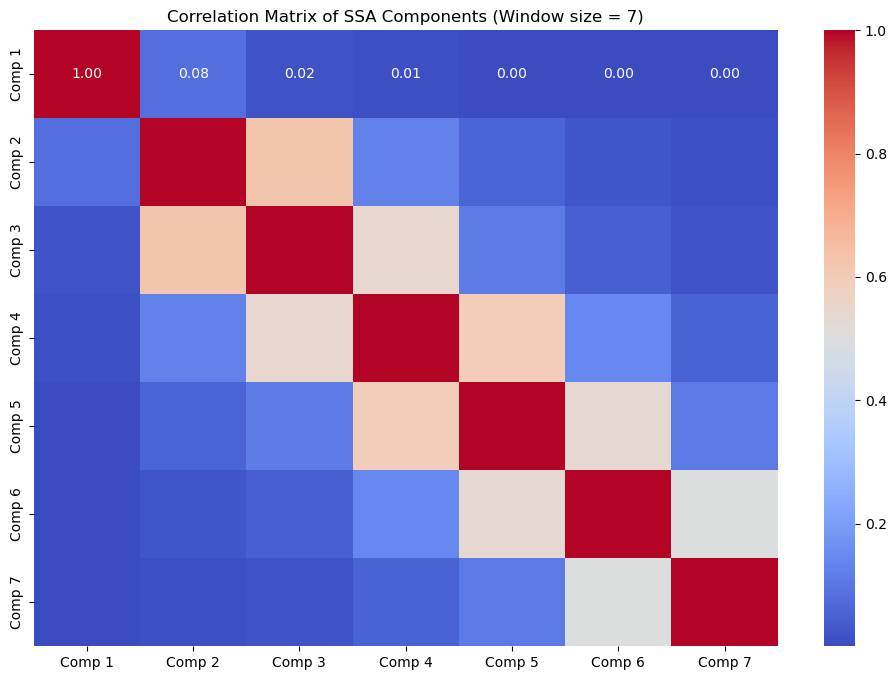

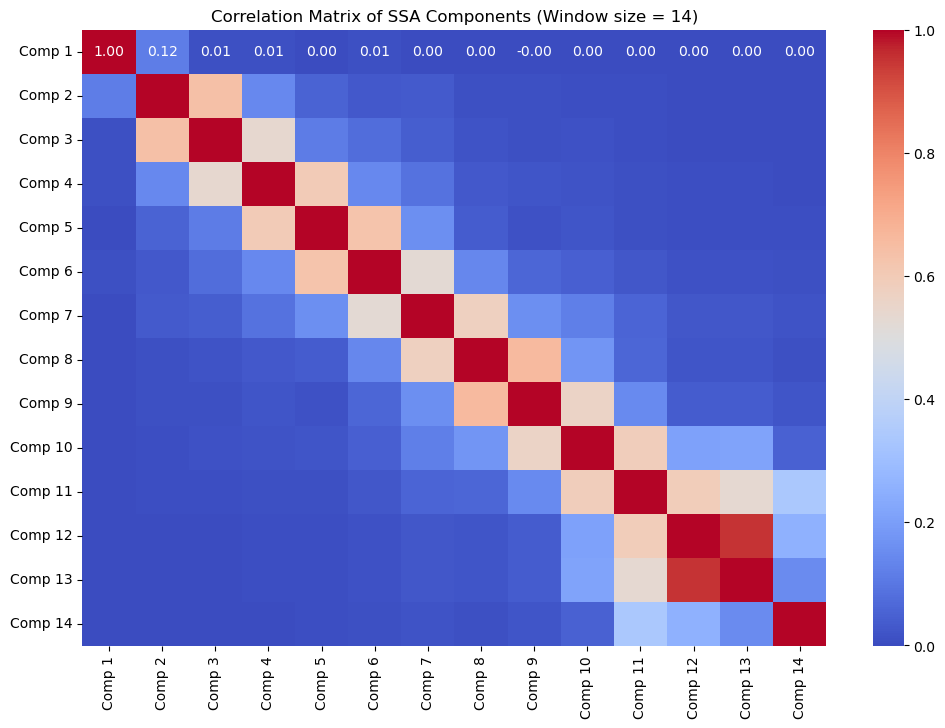

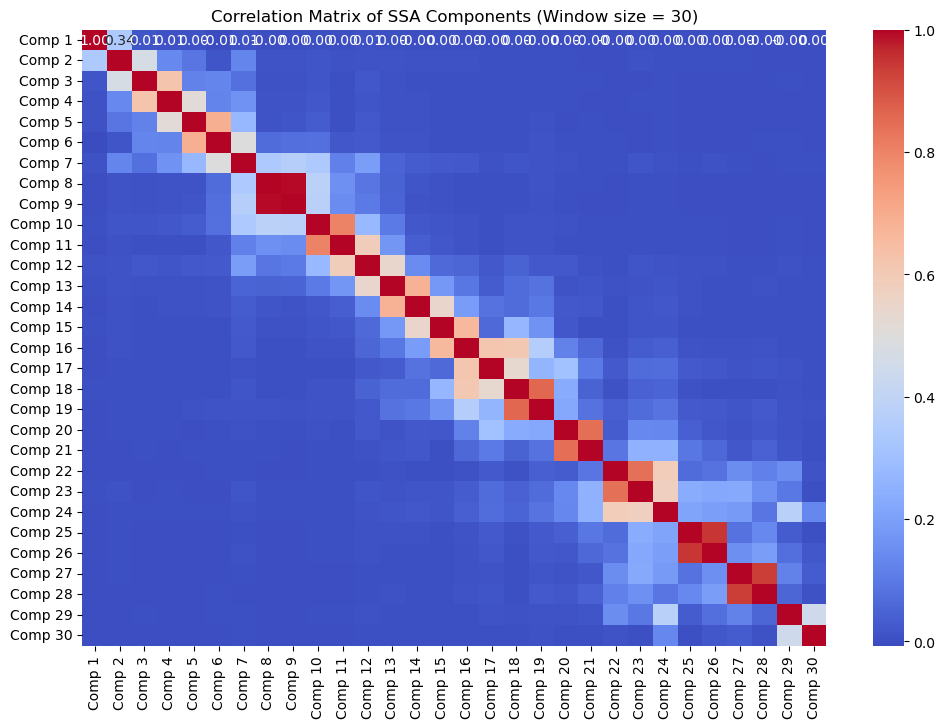

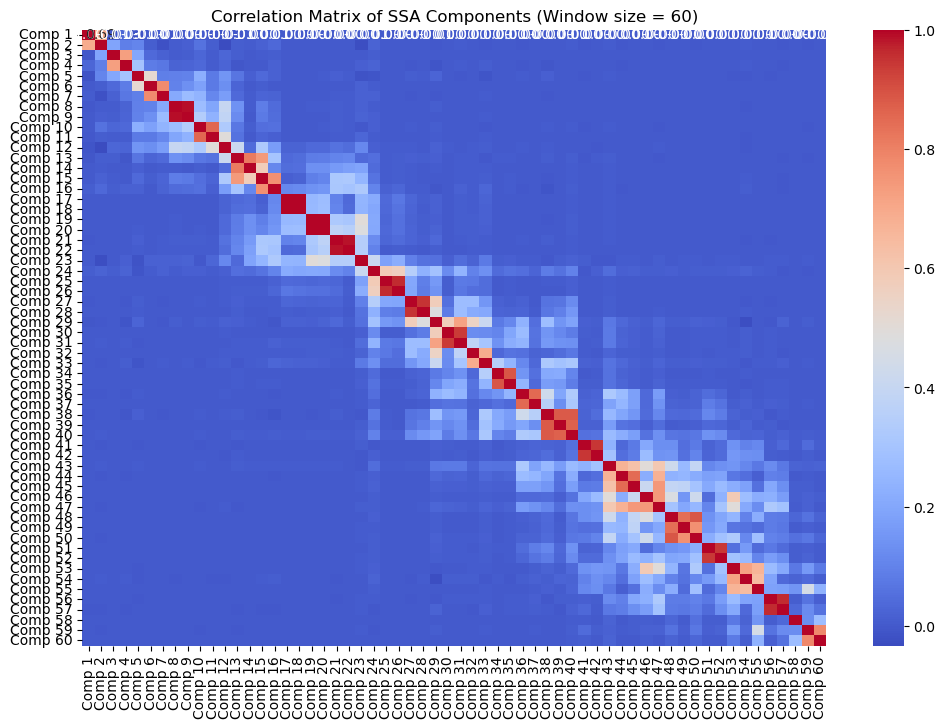

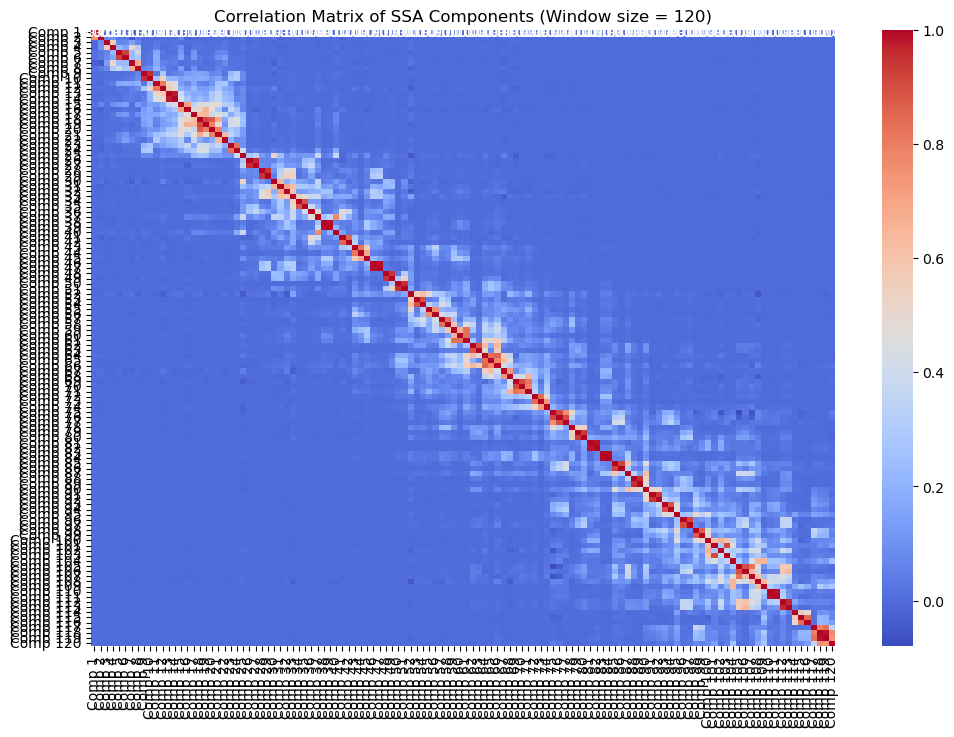

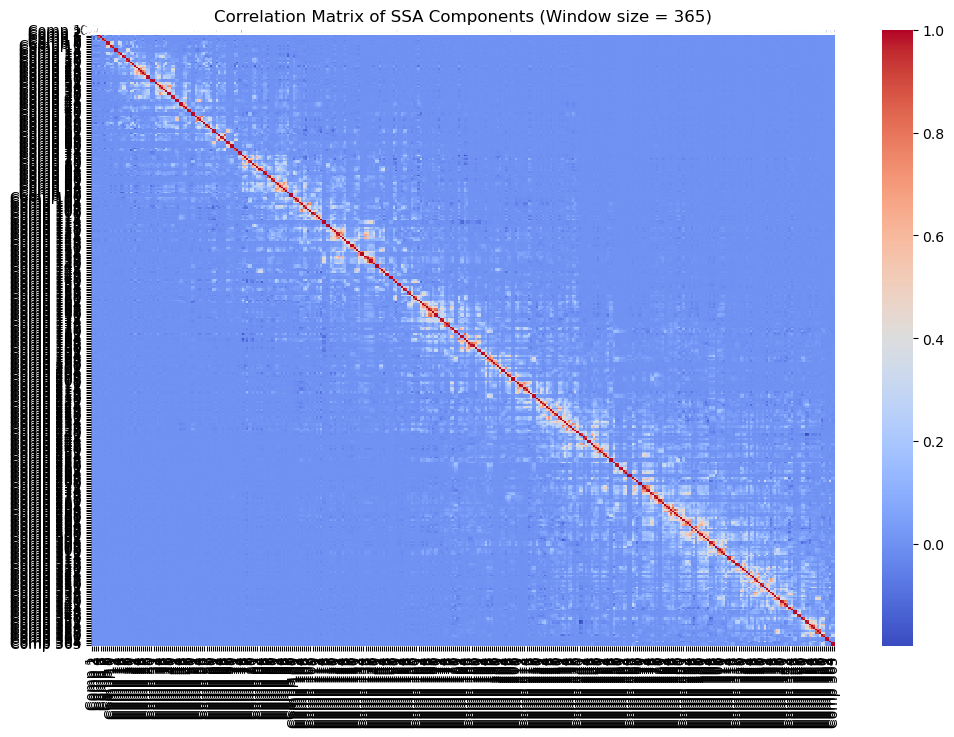

In [29]:
for res in ssa_results:
    corr_plot(res)

In [66]:
def plot_ssa_components(X, ssa_result, timestamps, window_size, max_columns=4, n_components=None):
    if not n_components:
        n_components = np.shape(ssa_result)[0]
    elif np.shape(ssa_result)[0] < n_components:
        n_components = window_size
    else:
        n_components = n_components
        
    plt.figure(figsize=(12, 8))
    plt.title(f'SSA Decomposition (Window size = {window_size})', fontsize=16)
    
    plt.plot(timestamps, X, label='Original Series', linewidth=1, alpha = 0.5)

    for i in range(n_components):
        if i <= 30:
            plt.plot(timestamps, ssa_result[i], label=f'Component {i+1}', alpha=0.7)
    
    plt.xlabel('Date')
    plt.ylabel('Value')
    ncol = min(max_columns, n_components + 1)  # +1 for the original series
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=ncol)
    plt.show()

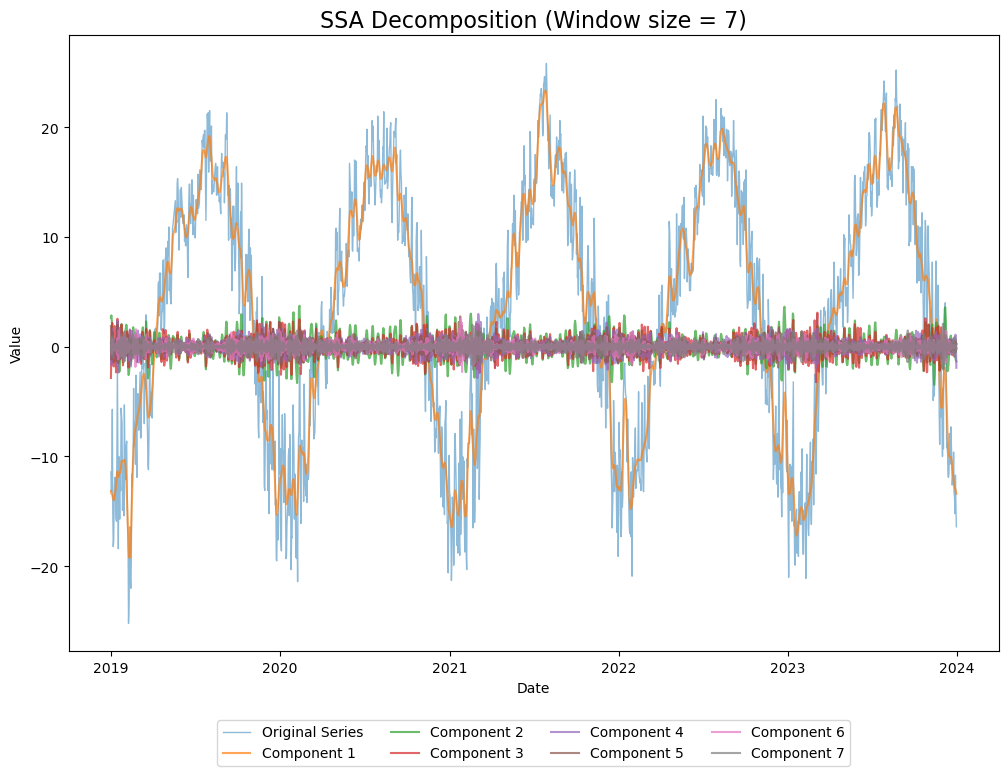

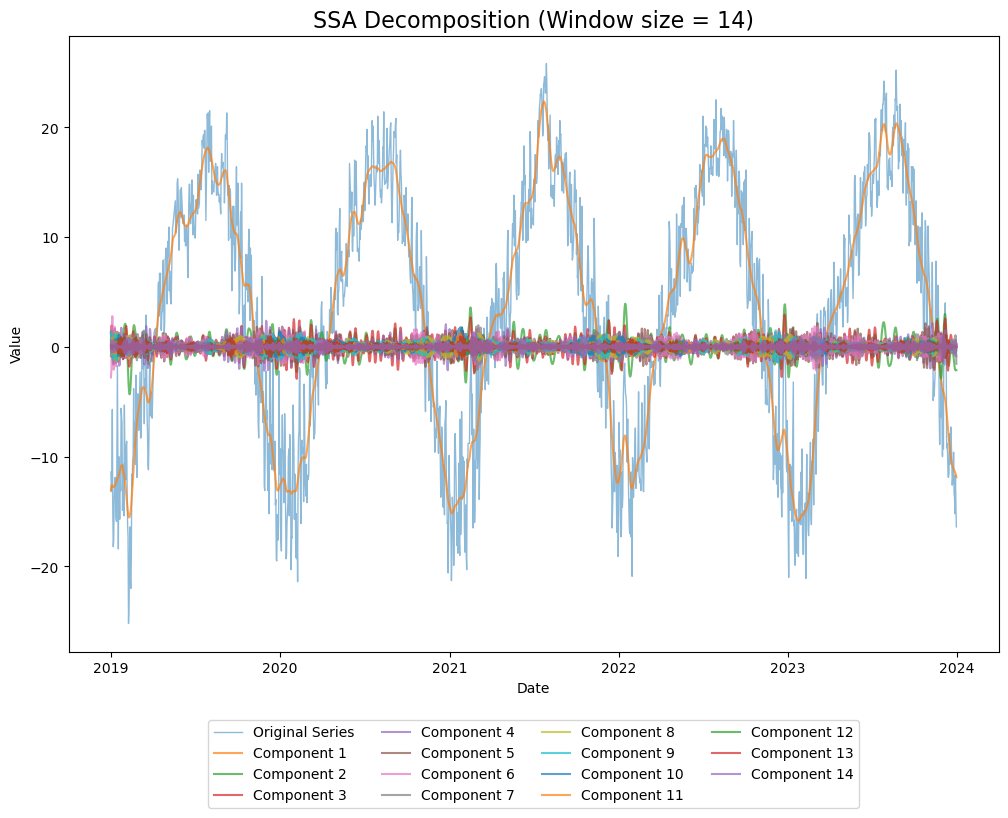

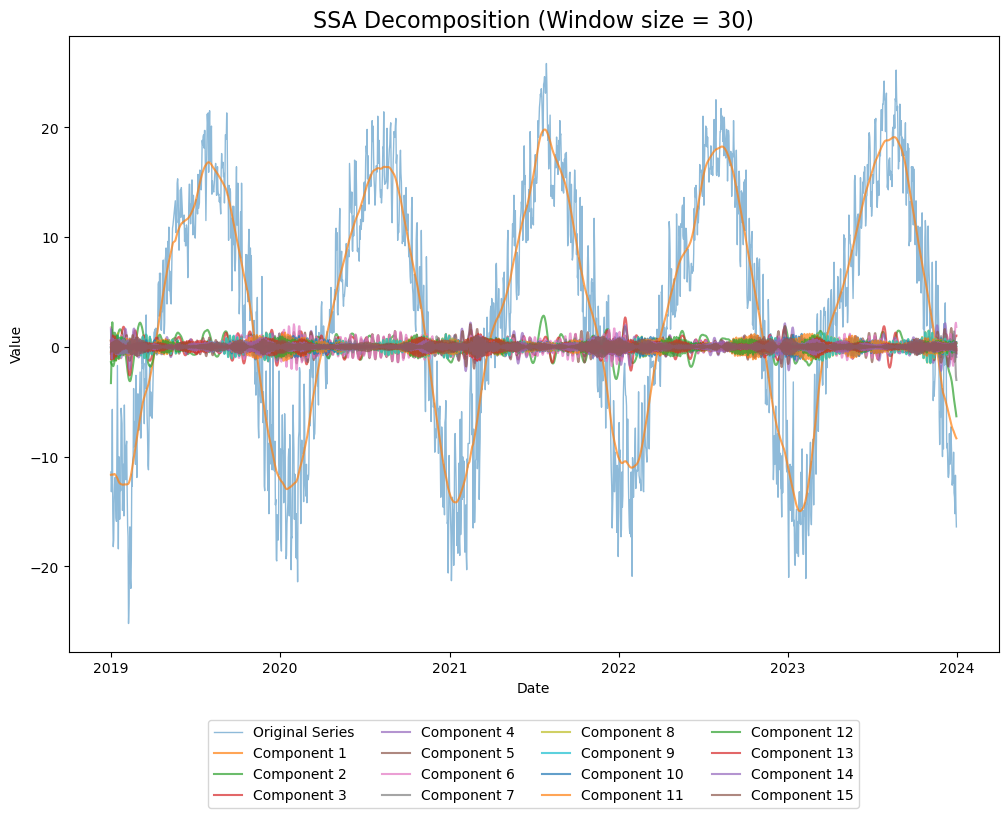

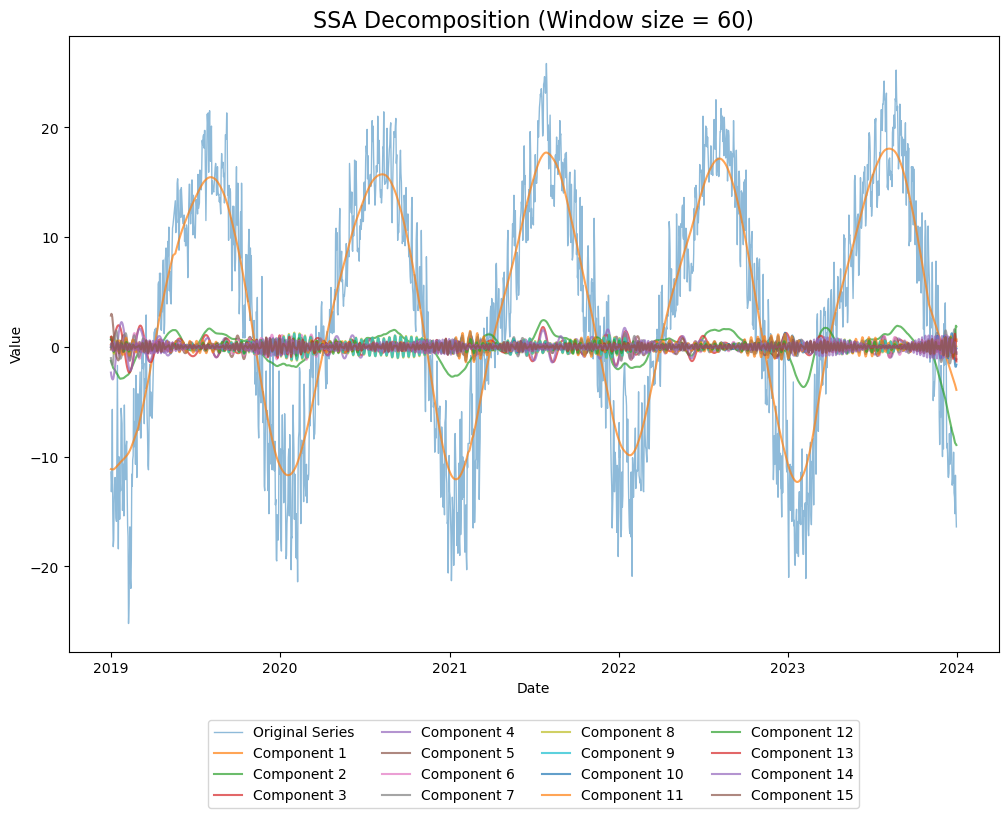

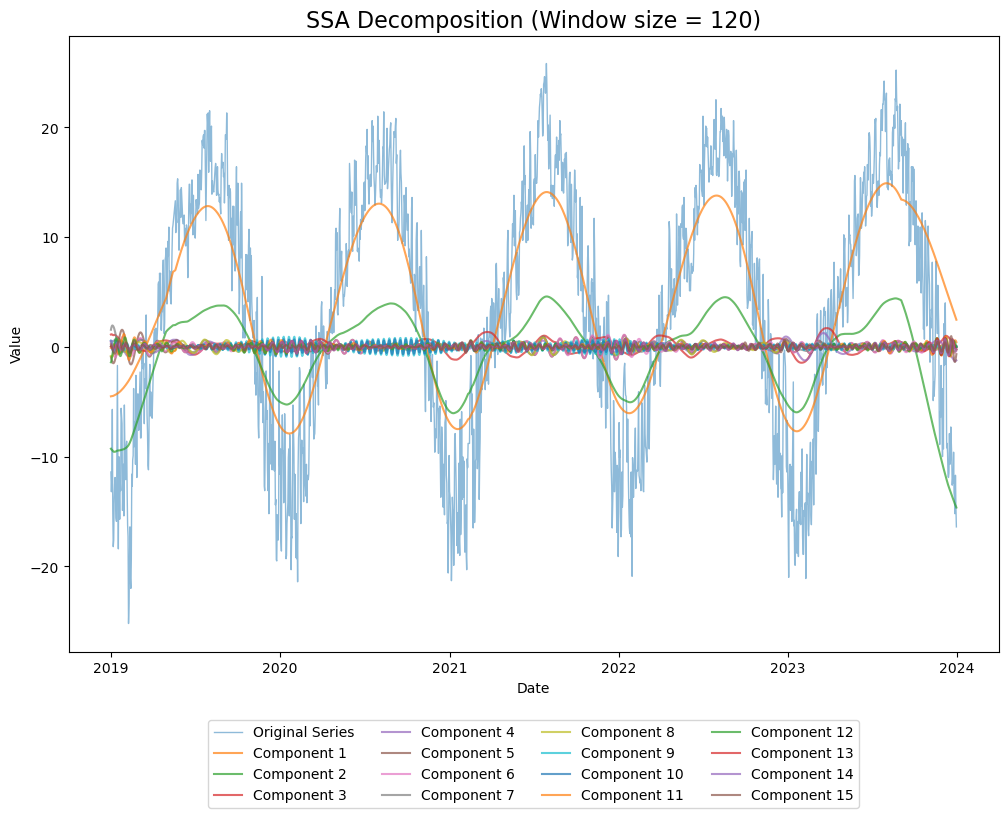

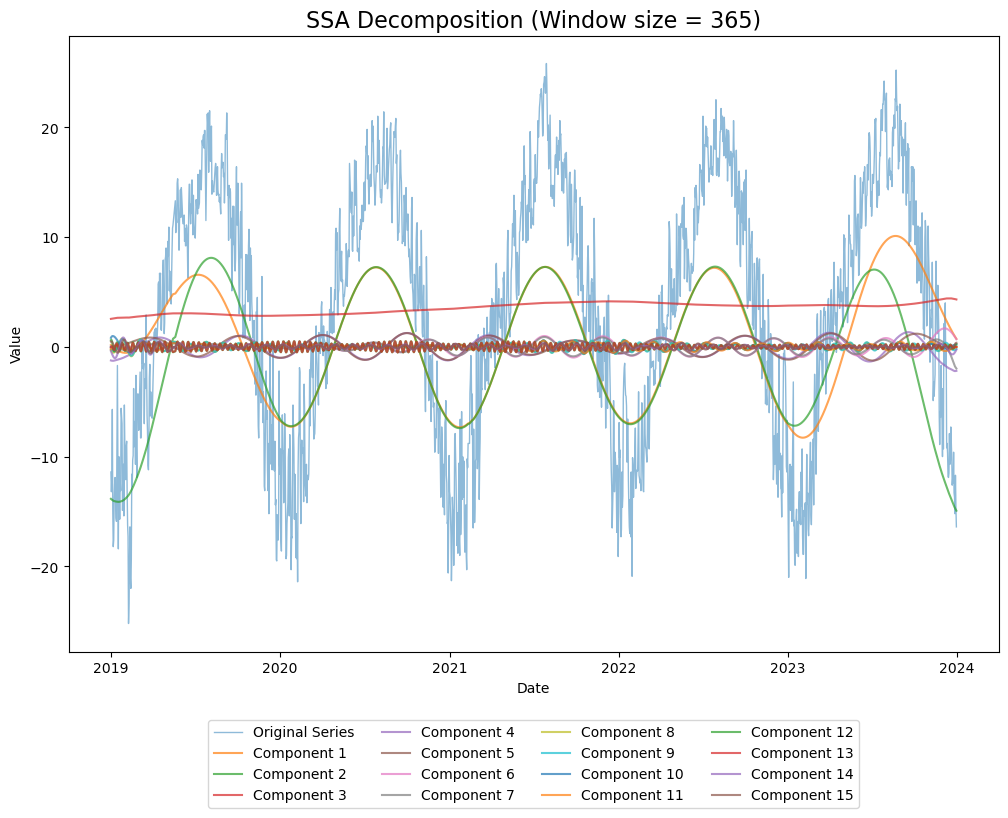

In [67]:
for res, ws in zip(ssa_results, window_sizes):
    plot_ssa_components(X, res, time_stamps, ws, n_components = 15)

In [53]:
data_slice = data['01-01-2023':]
data_slice

,Максимальная температура,Минимальная температура,Средняя температура,Скорость ветра,Осадки,Эффективная температура
Дата,,,,,,
2023-01-01,-4.5,-17.0,-11.6,4,1.0,-17.0
2023-01-02,-11.6,-27.0,-16.8,3,1.0,-21.9
2023-01-03,-11.0,-29.0,-21.0,2,0.0,-25.7
2023-01-04,-8.2,-22.0,-13.1,3,0.0,-18.0
2023-01-05,-6.2,-17.0,-10.8,4,0.0,-16.1
...,...,...,...,...,...,...
2023-12-27,-5.0,-18.3,-13.7,1,2.0,-17.3
2023-12-28,-6.0,-23.0,-15.2,1,1.0,-18.9
2023-12-29,-6.7,-15.0,-11.7,2,1.0,-15.8


In [54]:
X2,  time_stamps2 = data_slice['Средняя температура'].values, data_slice.index
ssa_results2 = [ssa(X2, ws) for ws in window_sizes[:-1]]

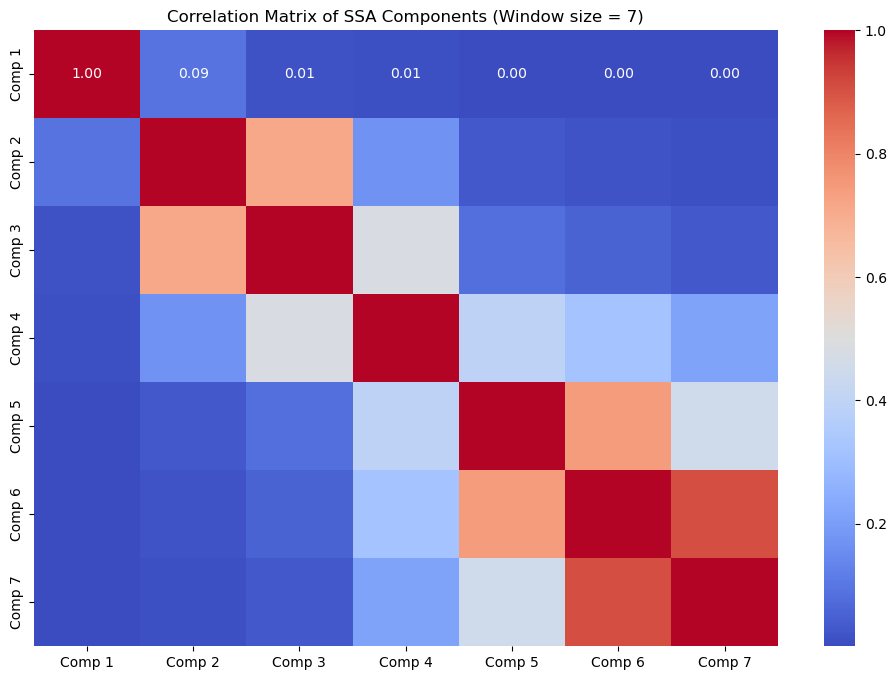

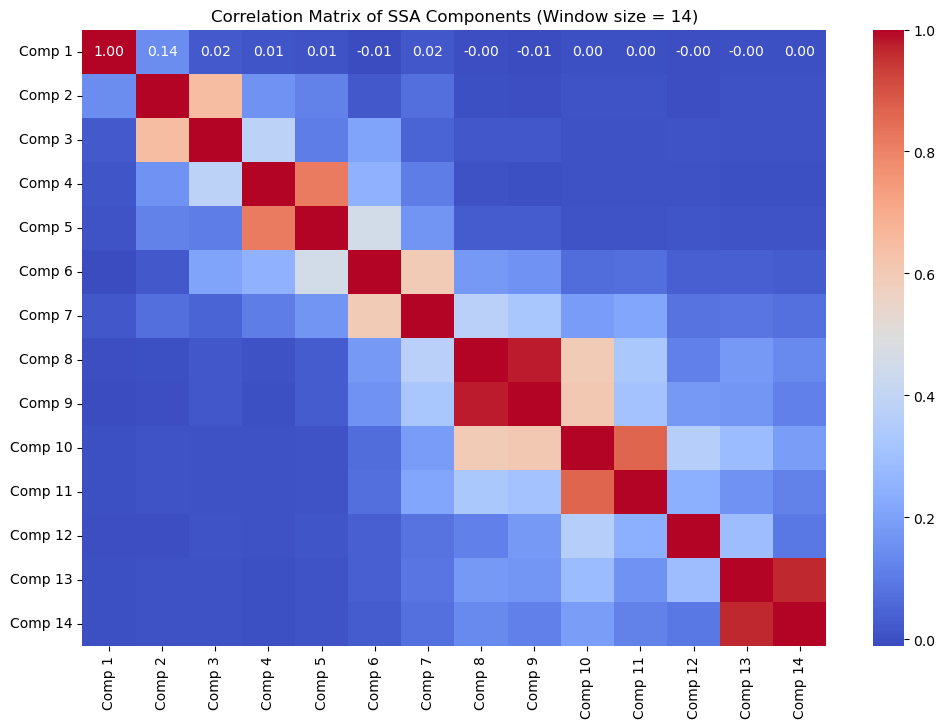

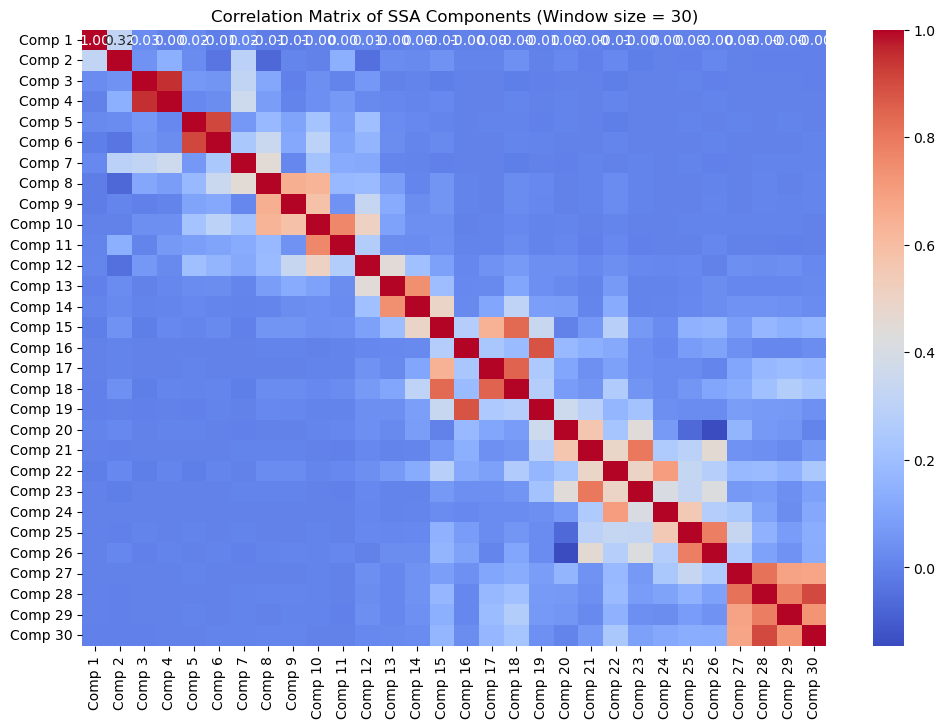

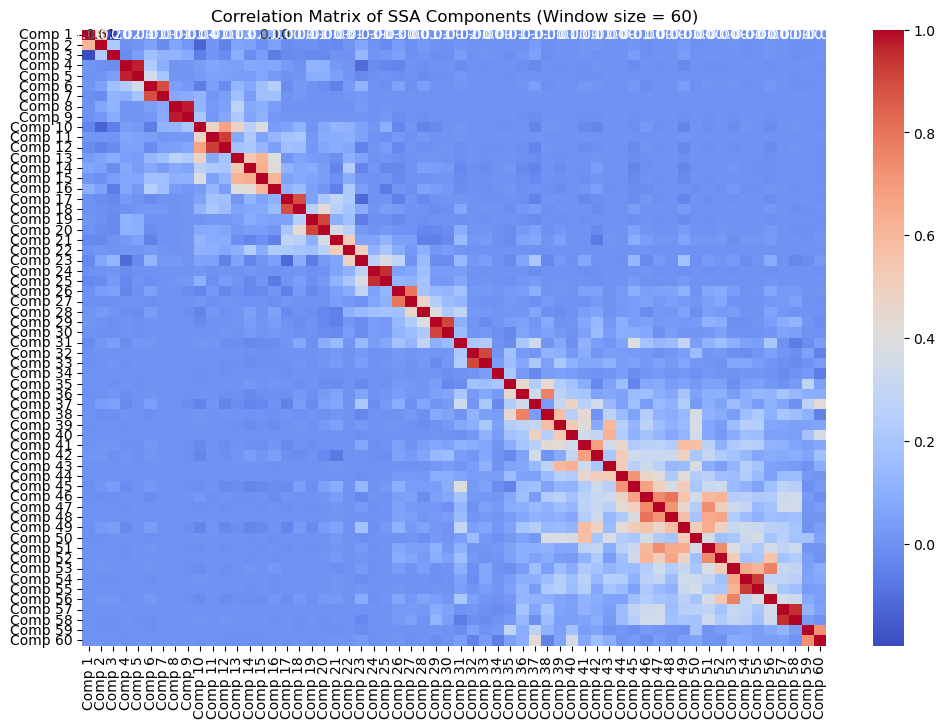

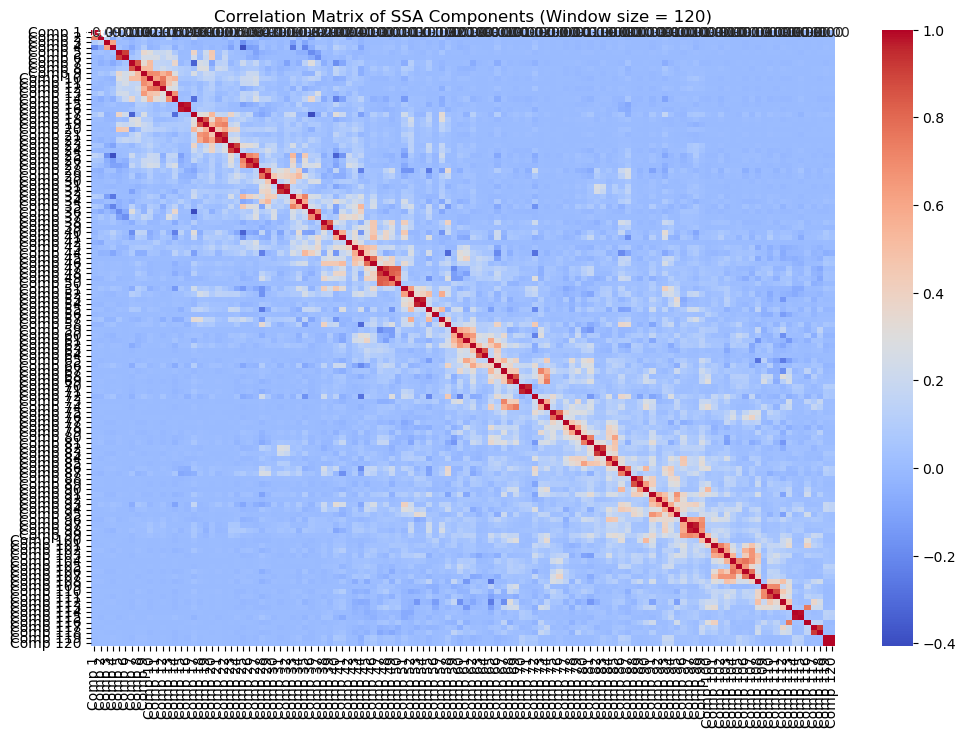

In [68]:
for res in ssa_results2:
    corr_plot(res)

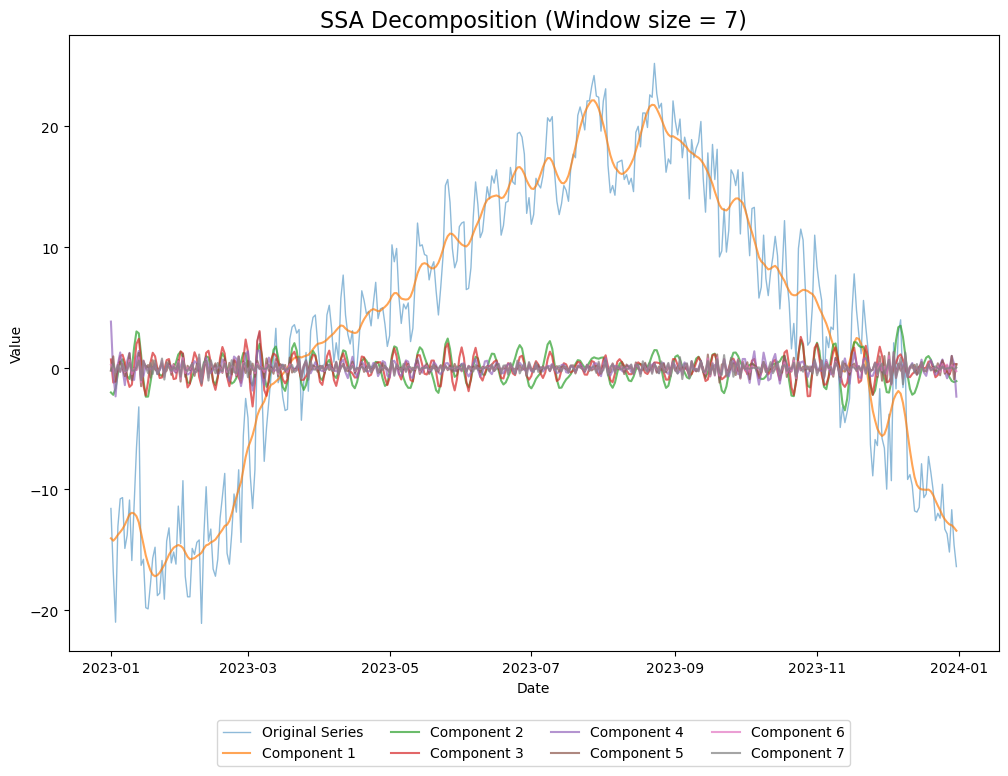

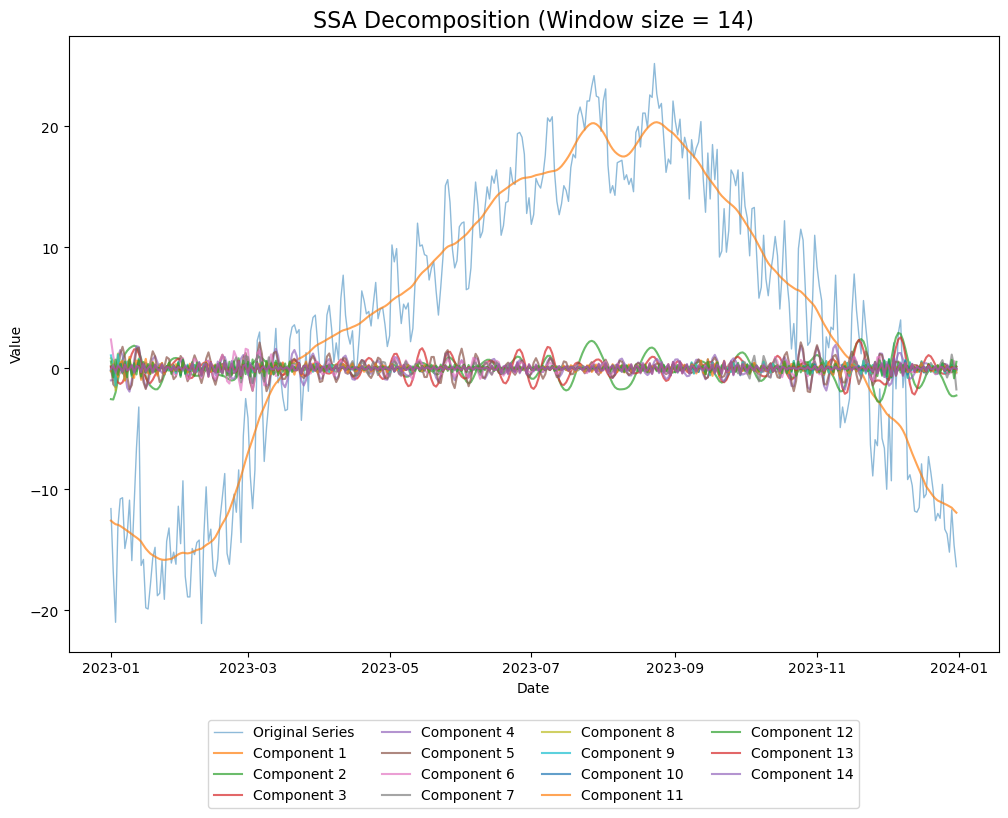

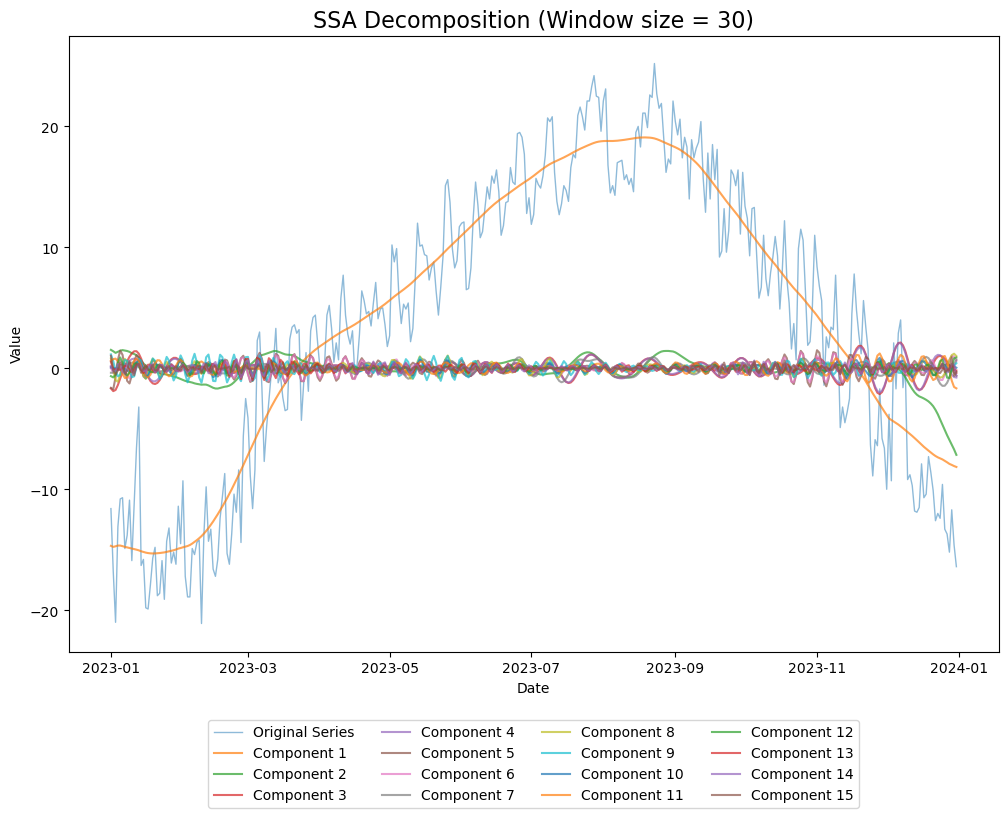

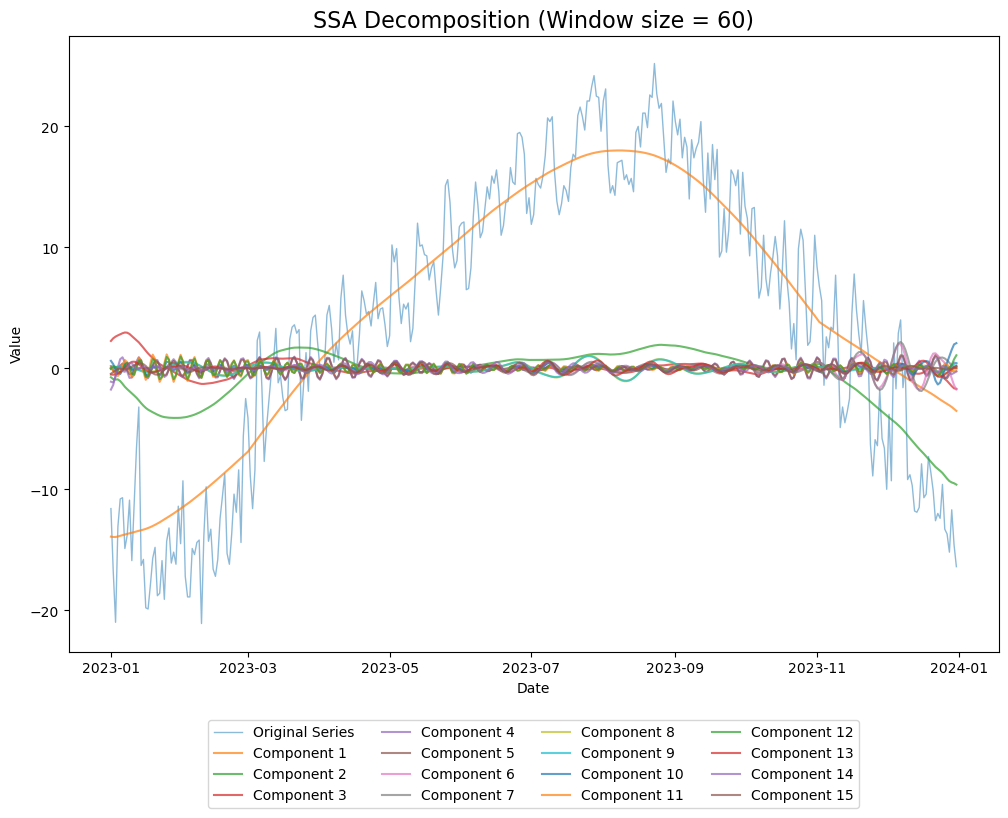

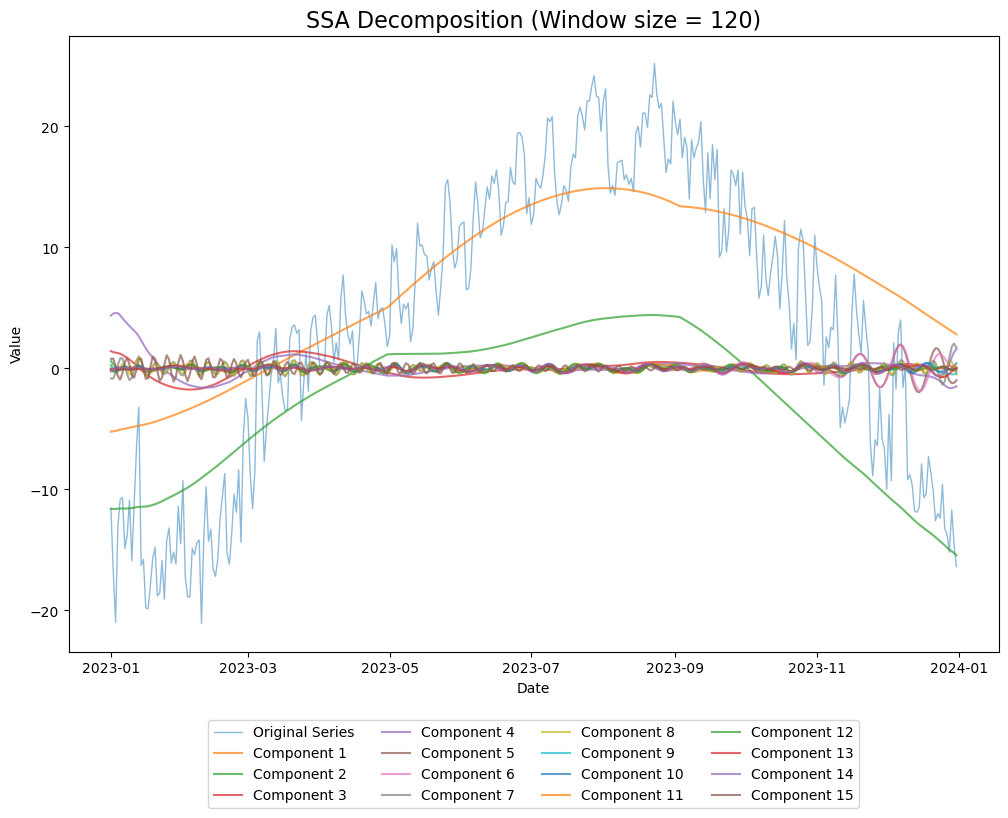

In [70]:
for res, ws in zip(ssa_results2, window_sizes[:-1]):
    plot_ssa_components(X2, res, time_stamps2, ws, n_components=15)